## Imports

In [1]:
# imports
from watertap.examples.flowsheets.RO_with_energy_recovery import RO_with_energy_recovery as swro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from watertap.tools.parameter_sweep import LinearSample, parameter_sweep
from idaes.core.util import model_statistics as ms

from pyomo.environ import (
    units as pyunits,
)

## Create Data for Surrogate Model

In [2]:
# build parameter sweep

def get_metrics(m, num_samples):
    sweep_params = {}

    sweep_params["recovery"] = LinearSample(
        m.fs.RO.recovery_mass_phase_comp[0, "Liq", "H2O"],
        0.05, 0.625, num_samples
    )

    outputs = {}

    outputs["hwp"] = m.fs.costing.annual_water_production / (365.25 * 24)
    outputs["sec"] = m.fs.costing.specific_energy_consumption
    outputs["area"] = m.fs.RO.area

    return sweep_params, outputs

def unfix_dof(m):
    m.fs.RO.area.fix(150)
    m.fs.costing.utilization_factor.fix()
    # m.fs.feed.properties[0].flow_vol_phase["Liq"].fix()

    m.fs.RO.recovery_mass_phase_comp[0, "Liq", "H2O"].unfix()
    m.fs.P1.control_volume.properties_out[0].pressure.unfix()

    return m    

def run_case(num_samples=31, filepath = None):
    m = swro.build()
    swro.set_operating_conditions(m,water_recovery=0.65)
    swro.initialize_system(m)
    m.fs.RO.recovery_mass_phase_comp[0, "Liq", "H2O"].unfix()
    m.fs.P1.control_volume.properties_out[0].pressure.unfix()
    m.fs.RO.area.fix(120)
    swro.solve(m)

    # m = unfix_dof(m)

    params, outputs = get_metrics(m, num_samples)
    
    global_results = parameter_sweep(
        m,
        params,
        outputs,
        csv_results_file_name=filepath,
        optimize_function=swro.solve,
        interpolate_nan_outputs=False,
    )

    return m, global_results



In [3]:
m = swro.main()
dwp = (m.fs.costing.annual_water_production()/365.25)

2023-05-19 18:46:45 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.
2023-05-19 18:46:45 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.
2023-05-19 18:46:46 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2023-05-19 18:46:47 [INFO] idaes.init.fs.RO: Initialization Complete: optimal - Optimal Solution Found
2023-05-19 18:46:47 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2023-05-19 18:46:48 [INFO] idaes.init.fs.RO: Initialization Complete: optimal - Optimal Solution Found
2023-05-19 18:46:48 [INFO] idaes.init.fs.feed: Initialization Complete.
2023-05-19 18:46:48 [INFO] idaes.init.fs.S1: Initialization Step 2 Complete: optimal - Optimal Solutio

In [4]:
m, results = run_case()

2023-05-19 18:46:49 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.
2023-05-19 18:46:49 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.
2023-05-19 18:46:50 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2023-05-19 18:46:50 [WARNING] idaes.init.fs.RO: Trouble solving unit model fs.RO, trying one more time
2023-05-19 18:46:50 [INFO] idaes.init.fs.RO: Initialization Complete: optimal - Optimal Solution Found
2023-05-19 18:46:50 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2023-05-19 18:46:50 [INFO] idaes.init.fs.RO: Initialization Complete: optimal - Optimal Solution Found
2023-05-19 18:46:50 [INFO] idaes.init.fs.feed: Initialization Complete.

/home/akshay/watertap_dev/watertap/watertap/tools/parameter_sweep/parameter_sweep_writer.py:87: UserWarning: No results will be writen to disk as h5_results_file_name and csv_results_file_name are both None
  warnings.warn(


Text(0.5, 1.0, 'Specific Energy Consumption vs. Recovery')

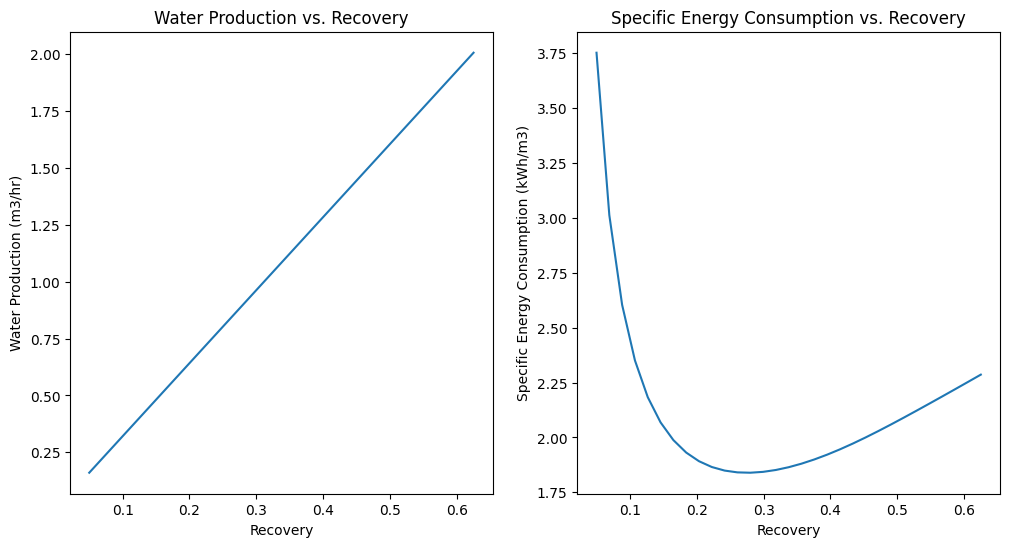

In [5]:
recovery = results[0][:,0]
water_prod = results[0][:,1]
sec = results[0][:,2]

#plot the recovery versus water production and sec on two subplots
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(recovery, water_prod)
ax[0].set_xlabel("Recovery")
ax[0].set_ylabel("Water Production (m3/hr)")
ax[0].set_title("Water Production vs. Recovery")
ax[1].plot(recovery, sec)
ax[1].set_xlabel("Recovery")
ax[1].set_ylabel("Specific Energy Consumption (kWh/m3)")
ax[1].set_title("Specific Energy Consumption vs. Recovery")



## Create operational model surrogate

In [6]:
from pyomo.environ import (
    ConcreteModel,
    Block,
    Var,
    Param,
    Constraint,
    Expression,
    exp,
    Objective,
    NonNegativeReals,
    minimize, 
    SolverFactory,
    )

In [7]:
# create a matrix of basis functions on recovery
tmp = ConcreteModel()

# create the parameters
# c.r = Param(initialize=recovery)
# c.e = Param(initialize=sec)
tmp.idx = range(len(recovery))
# create some fitting parameters 
tmp.a = Var(initialize=0.1,
          bounds=(None,None))

tmp.b = Var(initialize=0.1,
          bounds=(None,None))
tmp.c = Var(initialize=0.1,
          bounds = (None,None))

tmp.d = Var(initialize=0.1,
            bounds=(None,None))


tmp.y1 = Var(tmp.idx,
           initialize=0.1,)
tmp.y2 = Var(tmp.idx,
           initialize=0.1,)


# create basis functions using the fitting parameters
tmp.con1 = Constraint(tmp.idx,
    expr = [tmp.y1[i] == tmp.a * exp(-tmp.b * recovery[i]) for i in tmp.idx])
tmp.con2 = Constraint(tmp.idx,
    expr = [tmp.y2[i] == tmp.c * (recovery[i])**2 + tmp.d for i in tmp.idx])

tmp.y = Expression(tmp.idx,
                 expr = [tmp.y1[i] + tmp.y2[i] for i in tmp.idx])

# # create the objective function
tmp.obj = Objective(
    expr = sum((tmp.y1[i] + tmp.y2[i] - sec[i])**2 for i in tmp.idx),
    sense= minimize)

In [8]:
solver = SolverFactory('ipopt')
solver.solve(tmp, tee=False)
print()
print('*** Solution *** :')
print('a:', tmp.a())
print('b:', tmp.b())
print('c:', tmp.c())
print('d:', tmp.d())
print('fit: ', tmp.obj()/(len(recovery)))


*** Solution *** :
a: 5.407779687436562
b: 20.036887914806563
c: 1.439852873753575
d: 1.7139895919715327
fit:  0.0005194819184729786


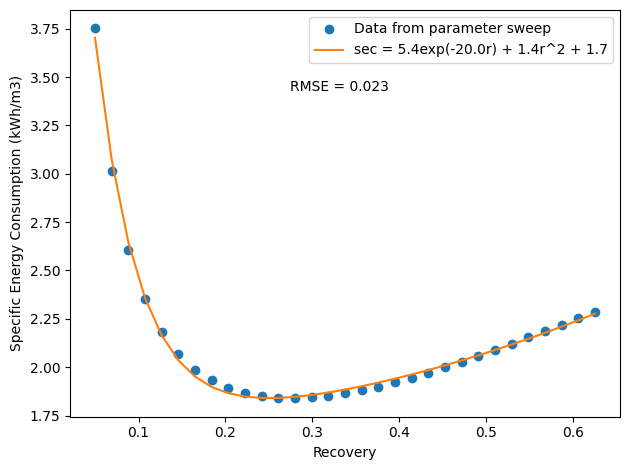

In [9]:
fig, ax = plt.subplots()
ax.plot(recovery, sec, 'o')
ax.plot(recovery, np.array([tmp.y1[i].value + tmp.y2[i].value for i in tmp.idx]))
l1 = "Data from parameter sweep"
l2 = "sec = {}exp(-{}r) + {}r^2 + {}".format(round(tmp.a(),1), round(tmp.b(),1), round(tmp.c(),1), round(tmp.d(),1))
# add an annotation for the fit and label it mean squared error
ax.annotate("RMSE = {}".format(round(np.sqrt(tmp.obj()/(len(recovery))),3)), xy=(0.4,0.8), xycoords='axes fraction')
ax.legend([l1,l2])
# create axis labels
ax.set_xlabel("Recovery")
ax.set_ylabel("Specific Energy Consumption (kWh/m3)")
fig.tight_layout()

Water production per unit recovery:  3.2100572110128867


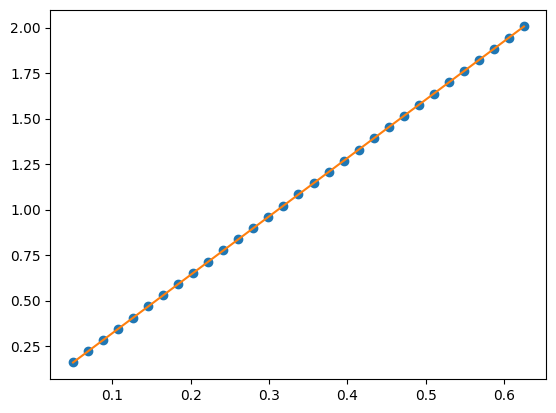

In [10]:
wpc = water_prod[-1]/recovery[-1]
print("Water production per unit recovery: ", wpc)
# plot the fit of using wpc as a model for water production
fig, ax = plt.subplots()
ax.plot(recovery, water_prod, 'o')
ax.plot(recovery, np.array([wpc*r for r in recovery]))

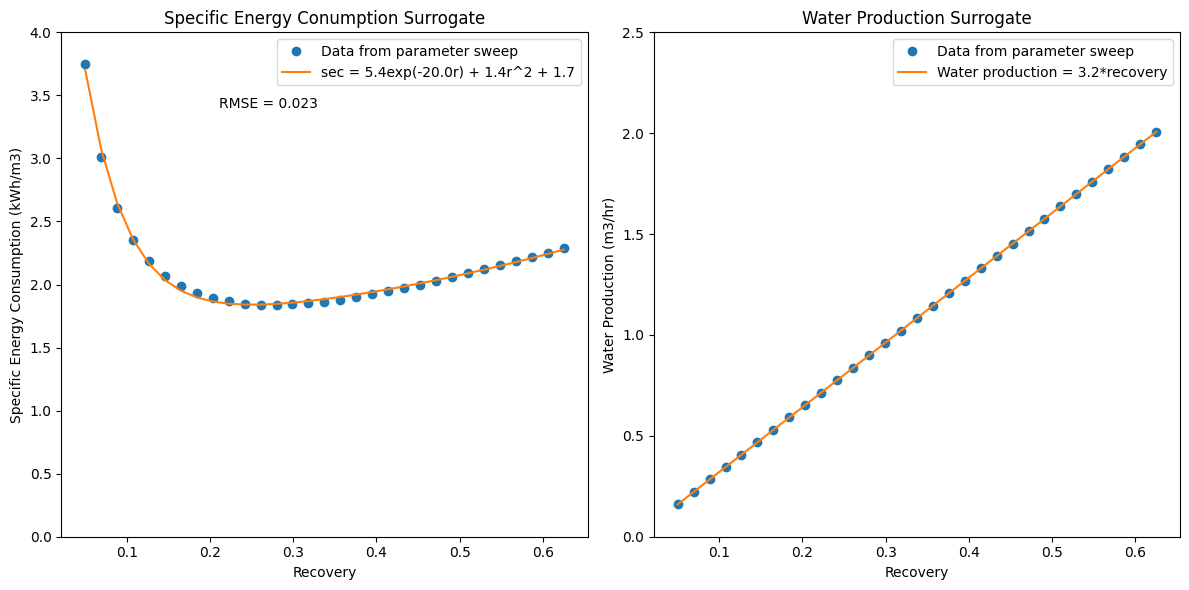

In [11]:
# combine the plots in the above two cells into subplots
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(recovery, sec, 'o')
ax[0].plot(recovery, np.array([tmp.y1[i].value + tmp.y2[i].value for i in tmp.idx]))
l1 = "Data from parameter sweep"
l2 = "sec = {}exp(-{}r) + {}r^2 + {}".format(round(tmp.a(),1), round(tmp.b(),1), round(tmp.c(),1), round(tmp.d(),1))
# add an annotation for the fit and label it mean squared error
ax[0].annotate("RMSE = {}".format(round(np.sqrt(tmp.obj()/(len(recovery))),3)), xy=(0.3,0.85), xycoords='axes fraction')
ax[0].legend([l1,l2])
# create axis labels
ax[0].set_xlabel("Recovery")
ax[0].set_ylabel("Specific Energy Consumption (kWh/m3)")
ax[0].set_title("Specific Energy Conumption Surrogate")
ax[0].set_ylim([0, 4])

ax[1].plot(recovery, water_prod, 'o')
ax[1].plot(recovery, np.array([wpc*r for r in recovery]))
ax[1].set_xlabel("Recovery")
ax[1].set_ylabel("Water Production (m3/hr)")
ax[1].set_title("Water Production Surrogate")
# add legend
ax[1].legend(["Data from parameter sweep", "Water production = {}*recovery".format(round(wpc,1))])
ax[1].set_ylim([0, 2.5])

fig.tight_layout()

## Surrogate multiperiod optimization

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.])

In [21]:
# create pyomo block structure
model = ConcreteModel()
model.mpfs = Block()
model.T = int(24 * 7)  # number of time steps (default unit hours) # TODO replace with actual time units
model.t = range(model.T)  # index for time steps

# import some parameters
a = tmp.a()
b = tmp.b()
c = tmp.c()
d = tmp.d()

peak_summer_weekday_rate = 0.484 * np.hstack([np.ones(int(model.T/2)), np.ones(int(model.T/2))*2]) * pyunits.USD_2018 / pyunits.kWh
peak_summer_weekday_demand = 6.67 * pyunits.USD_2018 / pyunits.kW

# add critical variables indexed by model.t
model.mpfs.recovery = Var(model.t,
                    initialize=0.5,
                    bounds=(0,0.65),
                    units = pyunits.dimensionless)
model.mpfs.specific_energy_consumption = Var(model.t,
                                           bounds=(0,None),
                                             units = pyunits.kWh/pyunits.m**3)
model.mpfs.water_production = Var(model.t,
                                bounds=(0,None),
                                units = pyunits.m**3/pyunits.hr)
model.mpfs.power_consumption = Var(model.t,
                                bounds=(0,None),
                                units = pyunits.kW)

# create model equality constraints using surrogates
@model.mpfs.Constraint(model.t)
def sec_constraint(m, i):
    return m.specific_energy_consumption[i] == a * exp(-b * m.recovery[i]) + c * m.recovery[i] + d

@model.mpfs.Constraint(model.t)
def wp_constraint(m, i):
    return m.water_production[i] == wpc * m.recovery[i]

@model.mpfs.Constraint(model.t)
def power_constraint(m, i):
    return m.power_consumption[i] == m.specific_energy_consumption[i] * m.water_production[i]

# import rate structure as parameters
model.costing = Block()

model.costing.peak_summer_weekday_rate = Param(model.t,
                       initialize = peak_summer_weekday_rate)

model.costing.peak_summer_weekday_demand = Param(initialize = peak_summer_weekday_demand)

model.mpfs.peak_demand = Var(bounds = (0,None))

@model.Constraint(model.t)
def peak_demand_constraint(m, i):
    return m.mpfs.peak_demand >= m.mpfs.power_consumption[i]


# add reliability / production constraint 
@model.Constraint()
def capacity_constraint(m):
    return sum(m.mpfs.water_production[i] for i in m.t) == dwp * 7

# add multiperiod costing expressions / constraints 


# add objective function
model.total_energy_cost = Expression(
    expr = sum(model.costing.peak_summer_weekday_rate[i] 
               * model.mpfs.power_consumption[i] for i in model.t) + 
               model.mpfs.peak_demand * model.costing.peak_summer_weekday_demand,
    doc = "total energy consumption over all time periods"
)

model.obj = Objective(
    expr = model.total_energy_cost,
    sense = minimize)


# solve model
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [22]:
# plot the optimized solution
# fig, ax = plt.subplots()
# ax.plot(model.mpfs.power_consumption.get_values())
model.mpfs.recovery.pprint()

recovery : Size=168, Index=mpfs.recovery_index, Units=dimensionless
    Key : Lower : Value               : Upper : Fixed : Stale : Domain
      0 :     0 :                0.65 :  0.65 : False : False :  Reals
      1 :     0 :                0.65 :  0.65 : False : False :  Reals
      2 :     0 :                0.65 :  0.65 : False : False :  Reals
      3 :     0 :                0.65 :  0.65 : False : False :  Reals
      4 :     0 :                0.65 :  0.65 : False : False :  Reals
      5 :     0 :                0.65 :  0.65 : False : False :  Reals
      6 :     0 :                0.65 :  0.65 : False : False :  Reals
      7 :     0 :                0.65 :  0.65 : False : False :  Reals
      8 :     0 :                0.65 :  0.65 : False : False :  Reals
      9 :     0 :                0.65 :  0.65 : False : False :  Reals
     10 :     0 :                0.65 :  0.65 : False : False :  Reals
     11 :     0 :                0.65 :  0.65 : False : False :  Reals
     12 :

## Extract flexlibility metrics

In [ ]:
# solve multiperiod problem for baseline rates

# solve multiperiod problem for TOU rates

# separate timesteps into charge and discharge 

# compute RTE

# compute Ed

# compute Pd

# compute LCOF

# plots